<a href="https://colab.research.google.com/github/mMitsu0/predicao_dengue/blob/main/tcc_monografia_grupo_gamma/f01_codes_modeling/dengue_previs%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **CENTRO UNIVERSITÁRIO NOSSA SENHORA DO PATROCÍNIO (CEUNSP)**
SALTO - SP

**BARACHELADO EM CIÊNCIA DA COMPUTAÇÕES**

# ***Análise Comparativa de Algoritmos de Machine Learning para Predição de Casos de Dengue.***

Autores:
*Matheus Mitsuo Tomotake Santos - RGM: 30248531*
*Pedro Gavioli Pinarde - RGM: 25798006*
*Lucas Felix Nogueira -RGM: 28851994*
*Gabriel Souza Cavalcante: RGM - 30386730*

**IMPORT DAS BIBLIOTECAS NECESSÁRIAS**

In [30]:
# === IMPORTS ===

# Utilidades do sistema e dados
import os  # Interações com o sistema operacional
import pandas as pd  # Manipulação de dados em tabelas (DataFrames)
import numpy as np  # Operações numéricas

# Visualização
import matplotlib.pyplot as plt  # Criação de gráficos
import seaborn as sns  # Visualizações estatísticas com estilo

# Requisições e arquivos
import requests  # Requisições HTTP (ex: baixar dados)
from io import StringIO  # Trata strings como arquivos

# Machine Learning clássico
from sklearn.model_selection import train_test_split  # Divide dados em treino/teste
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # Modelos de regressão com árvores
from sklearn.linear_model import LinearRegression  # Regressão linear
from xgboost import XGBRegressor  # Regressão com XGBoost (alta performance)
from sklearn.metrics import mean_squared_error, r2_score  # Métricas de avaliação (MSE e R²)
from sklearn.preprocessing import StandardScaler  # Normalização de features

# Deep Learning (LSTM)
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

# Se estiver rodando em Jupyter, ative inline; senão ignore
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except:
    pass


**CONEXÃO COM A API E DOWNLOAD DOS DADOS**

In [31]:
import os
import requests
import pandas as pd
from io import StringIO
from datetime import datetime

# === 1. DOWNLOAD DOS DADOS ===
estados_ibge = {
    "AC": [1200401], "AL": [2704302], "AM": [1302603], "AP": [1600303],"BA": [2927408], "CE": [2304400], "DF": [5300108], "ES": [3205309],
    "GO": [5208707], "MA": [2111300], "MG": [3106200], "MS": [5002704],
    "MT": [5103403], "PA": [1501402], "PB": [2507507], "PE": [2611606],"PI": [2211001], "PR": [4106902], "RJ": [3304557], "RN": [2408102],
    "RO": [1100205], "RR": [1400100], "RS": [4314902], "SC": [4205407],
    "SE": [2800308], "SP": [3550308], "TO": [1721000]
}

def baixar_dados_por_estado(diretorio_saida="data/raw", ano_inicio=2001, ano_fim=None):
    os.makedirs(diretorio_saida, exist_ok=True)
    base_url = "https://info.dengue.mat.br/api/alertcity"
    dfs = []

    # define ano final como o ano atual se não for passado
    if ano_fim is None:
        ano_fim = datetime.now().year

    for estado, municipios in estados_ibge.items():
        for geocode in municipios:
            params = {
                "geocode": geocode,
                "disease": "dengue",
                "format": "csv",
                "ew_start": 1,
                "ew_end": 52,
                "ey_start": ano_inicio,
                "ey_end": ano_fim
            }
            url = f"{base_url}?{'&'.join([f'{k}={v}' for k,v in params.items()])}"
            try:
                response = requests.get(url)
                if response.status_code == 200:
                    df = pd.read_csv(StringIO(response.text))
                    df["estado"] = estado
                    df["codigo_ibge"] = geocode
                    dfs.append(df)
                    print(f"✓ Dados coletados para {estado} ({ano_inicio}-{ano_fim})")
                else:
                    print(f"⚠️ Falha {estado} - status {response.status_code}")
            except Exception as e:
                print(f"❌ Erro com {estado}: {e}")

    if dfs:
        df_final = pd.concat(dfs, ignore_index=True)
        caminho_csv = f"{diretorio_saida}/dengue_{ano_inicio}_{ano_fim}_por_estado.csv"
        df_final.to_csv(caminho_csv, index=False)
        print(f"\n✅ Dados salvos em {caminho_csv}")
    else:
        print("Nenhum dado coletado.")


**REFINAMENTO DOS DADOS / FEATURES**

In [32]:
# === 2. ENGENHARIA DE FEATURES ===
def carregar_e_limpar(caminho_arquivo):
    return pd.read_csv(caminho_arquivo)

def adicionar_variaveis_temporais(df):
    df['data_iniSE'] = pd.to_datetime(df['data_iniSE'])
    df['epidemiological_year'] = df['data_iniSE'].dt.year
    df['epidemiological_week'] = df['data_iniSE'].dt.isocalendar().week

    df['casos_lag_1'] = df['casos'].shift(1)
    df['casos_lag_2'] = df['casos'].shift(2)
    df['casos_lag_3'] = df['casos'].shift(3)
    df['casos_media_3'] = df[['casos_lag_1', 'casos_lag_2', 'casos_lag_3']].mean(axis=1)
    return df

def remover_outliers(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[feature] >= Q1 - 1.5 * IQR) & (df[feature] <= Q3 + 1.5 * IQR)]
    return df

**MODELOS DE PREDIÇÃO**

In [33]:
# === 3.1 MODELOS MACHINE LEARNING ===
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

def treinar_modelos_classicos(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    modelos = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(random_state=random_state),
        "Gradient Boosting": GradientBoostingRegressor(random_state=random_state),
        "XGBoost": XGBRegressor(random_state=random_state)
    }

    resultados = {}
    modelos_treinados = {}

    for nome, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        mse  = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2   = r2_score(y_test, y_pred)
        nrmse_pct = (rmse / np.mean(y_test) * 100) if np.mean(y_test) != 0 else np.nan

        resultados[nome] = (mse, rmse, r2, nrmse_pct)
        modelos_treinados[nome] = modelo

    return resultados, modelos_treinados


In [34]:
# === 3.2 LSTM
import numpy as np
import pandas as pd
from datetime import date
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

def _ord_from_year_week(y, w):
    # número ordenável YYYYWW (apenas para ordenar/particionar)
    return int(f"{int(y):04d}{int(w):02d}")

def _build_sequences_by_state(df, features, lookback=8, horizon=1):

    X_list, y_list = [], []
    # Ordenação global por estado/tempo
    df = df.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).copy()

    for gid, g in df.groupby("codigo_ibge"):
        g = g.copy()
        g["ord"] = g.apply(lambda r: _ord_from_year_week(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
        g = g.sort_values("ord")

        feats_arr   = g[features].to_numpy(dtype=float)
        target_arr  = g["casos"].to_numpy(dtype=float)

        if len(g) < lookback + horizon:
            continue

        for t in range(lookback, len(g) - horizon + 1):
            X_list.append(feats_arr[t - lookback:t])
            y_list.append(target_arr[t + horizon - 1])

    X = np.array(X_list)  # (n_amostras, lookback, n_features)
    y = np.array(y_list)  # (n_amostras,)
    return X, y

def _temporal_mask_by_cutoff(df, lookback, horizon, cutoff=(2025,1)):

    # Para reproduzir a mesma contagem das sequências, precisamos revarrer as chaves
    ord_cut = _ord_from_year_week(*cutoff)
    mask_list = []

    for gid, g in df.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).groupby("codigo_ibge"):
        g = g.copy()
        g["ord"] = g.apply(lambda r: _ord_from_year_week(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
        g = g.sort_values("ord")
        if len(g) < lookback + horizon:
            continue
        # alvo na posição t+h-1
        ord_vec = g["ord"].to_numpy()
        for t in range(lookback, len(g) - horizon + 1):
            ord_target = ord_vec[t + horizon - 1]
            mask_list.append(ord_target < ord_cut)  # True=train, False=test

    mask = np.array(mask_list, dtype=bool)
    return mask

def treinar_lstm_separado(
    df_feat_sem_outliers,
    features,
    lookback=8,
    horizon=1,
    cutoff_test=(2025,1),
    epochs=80,
    batch_size=256,
    lr=1e-3,
    verbose=1
):

    # Sanidade: sem NaN nas features
    df_seq = df_feat_sem_outliers.copy()
    df_seq[features] = df_seq[features].fillna(method="ffill").fillna(method="bfill")
    df_seq["casos"] = df_seq["casos"].astype(float)

    # 1) Sequências 3D por estado
    X_all, y_all = _build_sequences_by_state(df_seq, features, lookback=lookback, horizon=horizon)
    if len(X_all) == 0:
        raise ValueError("Não foi possível construir sequências para a LSTM. Verifique se há dados suficientes por estado.")

    # 2) Máscara temporal (True=train, False=test)
    mask_train = _temporal_mask_by_cutoff(df_seq, lookback, horizon, cutoff=cutoff_test)
    if mask_train.shape[0] != X_all.shape[0]:
        raise RuntimeError("Máscara temporal não alinhada com as sequências. Verifique a preparação dos dados.")

    X_tr, y_tr = X_all[mask_train], y_all[mask_train]
    X_te, y_te = X_all[~mask_train], y_all[~mask_train]

    # 3) Escalonamento apenas nas features (concatenando no eixo tempo)
    n_features = X_tr.shape[-1]
    scaler = StandardScaler()
    X_tr_2d = X_tr.reshape(-1, n_features)
    scaler.fit(X_tr_2d)

    X_tr_scaled = scaler.transform(X_tr_2d).reshape(X_tr.shape)
    X_te_scaled = scaler.transform(X_te.reshape(-1, n_features)).reshape(X_te.shape)

    # 4) Modelo LSTM
    def build_lstm(input_shape, lr=lr):
        inp = layers.Input(shape=input_shape)
        x = layers.LSTM(64, return_sequences=True)(inp)
        x = layers.Dropout(0.2)(x)
        x = layers.LSTM(32)(x)
        x = layers.Dense(16, activation="relu")(x)
        out = layers.Dense(1)(x)
        model = models.Model(inp, out)
        model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="mse")
        return model

    model_lstm = build_lstm((lookback, n_features), lr=lr)
    early = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
    plateau = callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5, monitor="val_loss")

    # 5) Treino
    hist = model_lstm.fit(
        X_tr_scaled, y_tr,
        validation_split=0.15,  # validação dentro do conjunto de treino (temporalmente já separou o teste)
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early, plateau],
        verbose=verbose
    )

    # 6) Avaliação
    y_hat_tr = model_lstm.predict(X_tr_scaled, verbose=0).ravel()
    y_hat_te = model_lstm.predict(X_te_scaled, verbose=0).ravel()

    def _metrics(y_true, y_pred):
        mse  = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2   = r2_score(y_true, y_pred)
        nrmse_pct = (rmse / np.mean(y_true) * 100) if np.mean(y_true) != 0 else np.nan
        return mse, rmse, r2, nrmse_pct

    mse_tr, rmse_tr, r2_tr, nrmse_tr = _metrics(y_tr, y_hat_tr)
    mse_te, rmse_te, r2_te, nrmse_te = _metrics(y_te, y_hat_te)

    print("\n=== LSTM - Métricas (Treino) ===")
    print(f"MSE (u²): {mse_tr:,.2f} | RMSE: {rmse_tr:,.2f} | R²: {r2_tr*100:,.2f}% | nRMSE: {nrmse_tr:,.2f}%")
    print("=== LSTM - Métricas (Teste)  ===")
    print(f"MSE (u²): {mse_te:,.2f} | RMSE: {rmse_te:,.2f} | R²: {r2_te*100:,.2f}% | nRMSE: {nrmse_te:,.2f}%")

    resultados_lstm = {"LSTM": (mse_te, rmse_te, r2_te, nrmse_te)}
    return resultados_lstm, model_lstm, scaler


**PLOTAGEM E AVALIAÇÃO DOS MODELOS**

In [35]:
def plot_comparacao_erros(modelos, mse_percentuais):
    df = pd.DataFrame({"Modelo": modelos, "Erro (%)": mse_percentuais})
    plt.figure(figsize=(10,6))
    sns.barplot(data=df, x="Modelo", y="Erro (%)", hue="Modelo", palette="viridis", legend=False)
    plt.title('Erro Quadrático Médio (%) por Modelo')
    plt.ylabel('Erro (%)')
    plt.xlabel('Modelos')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


**MAIN**

✓ Dados coletados para AC (2010-2025)
✓ Dados coletados para AL (2010-2025)
✓ Dados coletados para AM (2010-2025)
✓ Dados coletados para AP (2010-2025)
✓ Dados coletados para BA (2010-2025)
✓ Dados coletados para CE (2010-2025)
✓ Dados coletados para DF (2010-2025)
✓ Dados coletados para ES (2010-2025)
✓ Dados coletados para GO (2010-2025)
✓ Dados coletados para MA (2010-2025)
✓ Dados coletados para MG (2010-2025)
✓ Dados coletados para MS (2010-2025)
✓ Dados coletados para MT (2010-2025)
✓ Dados coletados para PA (2010-2025)
✓ Dados coletados para PB (2010-2025)
✓ Dados coletados para PE (2010-2025)
✓ Dados coletados para PI (2010-2025)
✓ Dados coletados para PR (2010-2025)
✓ Dados coletados para RJ (2010-2025)
✓ Dados coletados para RN (2010-2025)
✓ Dados coletados para RO (2010-2025)
✓ Dados coletados para RR (2010-2025)
✓ Dados coletados para RS (2010-2025)
✓ Dados coletados para SC (2010-2025)
✓ Dados coletados para SE (2010-2025)
✓ Dados coletados para SP (2010-2025)
✓ Dados cole

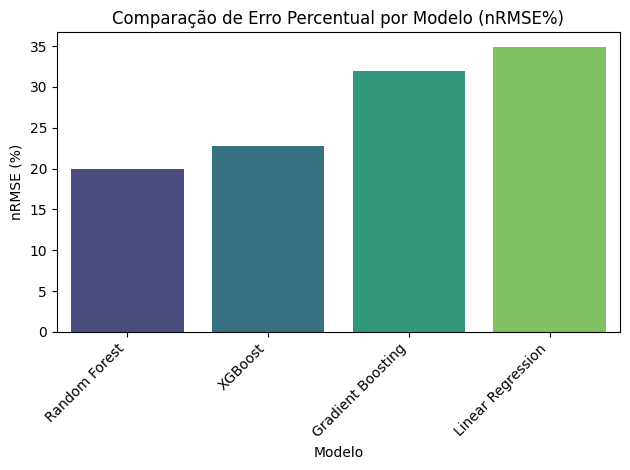

/tmp/ipython-input-4051456016.py:80: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_seq[features] = df_seq[features].fillna(method="ffill").fillna(method="bfill")


Epoch 1/120
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 8703.9883 - val_loss: 11155.5752 - learning_rate: 0.0010
Epoch 2/120
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 8277.3203 - val_loss: 10390.9297 - learning_rate: 0.0010
Epoch 3/120
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 7476.4663 - val_loss: 9817.9365 - learning_rate: 0.0010
Epoch 4/120
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 6970.5210 - val_loss: 9231.5947 - learning_rate: 0.0010
Epoch 5/120
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 6111.5107 - val_loss: 8585.3818 - learning_rate: 0.0010
Epoch 6/120
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 5781.3779 - val_loss: 7856.7349 - learning_rate: 0.0010
Epoch 7/120
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 5311.9937 - val_loss: 7177.9297 - learning_rate: 0.0010
Epoch 8/120
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 4297.7222 - val_loss: 6540.9653 - learning_rate: 0.0010
Epoch 9/120
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 4168.8901

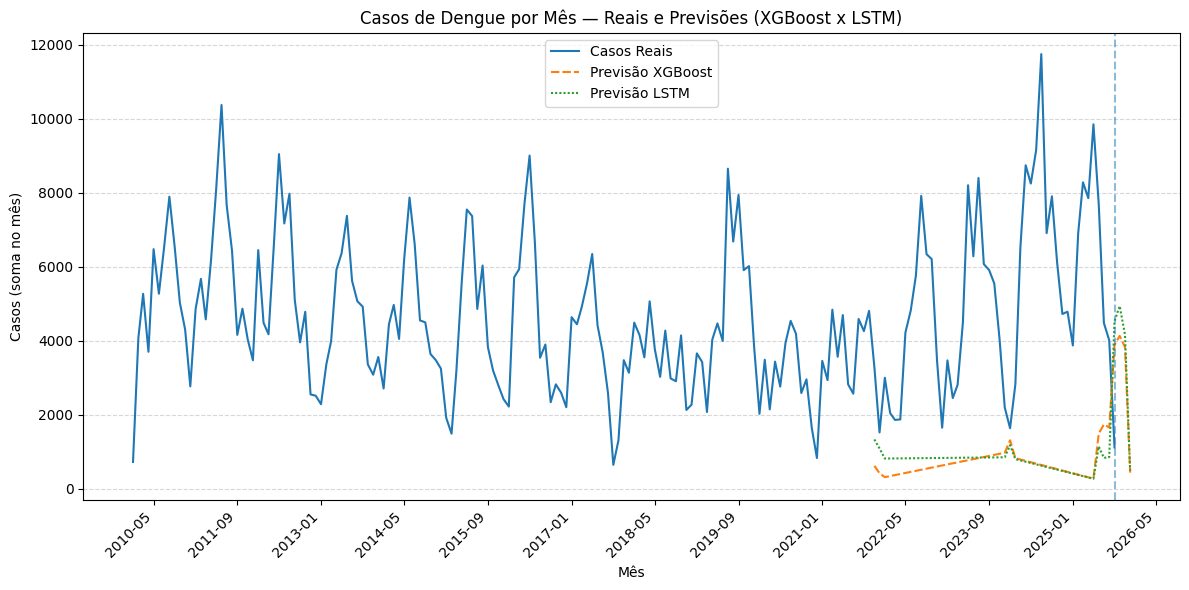

In [42]:
# === 5. EXECUÇÃO COMPLETA  (AJUSTADO COM LSTM e RANGE ÚNICO) ===
import os
from glob import glob
from datetime import date, timedelta, datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# >>> IMPORTS extras para LSTM
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

# --------------------------
# Configuração de anos (um único range para todo o pipeline)
# --------------------------
ANO_INICIO = 2010              # ajuste se quiser ainda mais histórico (ex.: 2001)
ANO_FIM    = 2025              # ou: datetime.now().year

# --------------------------
# Funções auxiliares (LSTM)
# --------------------------
def _ord_from_year_week(y, w):
    return int(f"{int(y):04d}{int(w):02d}")

def _build_sequences_by_state(df, features, lookback=8, horizon=1):
    """
    Constrói janelas 3D por estado (amostras, lookback, n_features) e o alvo y (1D).
    Respeita a ordem temporal ano/semana.
    """
    X_list, y_list = [], []
    df = df.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).copy()
    for gid, g in df.groupby("codigo_ibge"):
        g = g.copy()
        g["ord"] = g.apply(lambda r: _ord_from_year_week(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
        g = g.sort_values("ord")
        feats_arr = g[features].to_numpy(dtype=float)
        target_arr = g["casos"].to_numpy(dtype=float)
        if len(g) < lookback + horizon:
            continue
        for t in range(lookback, len(g) - horizon + 1):
            X_list.append(feats_arr[t - lookback:t])
            y_list.append(target_arr[t + horizon - 1])
    X = np.array(X_list)
    y = np.array(y_list)
    return X, y

def _temporal_mask_by_cutoff(df, lookback, horizon, cutoff=(2025,1)):
    """
    Gera máscara booleana para separar treino/teste por tempo com base em (ano, semana) do alvo.
    """
    ord_cut = _ord_from_year_week(*cutoff)
    mask_list = []
    for gid, g in df.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).groupby("codigo_ibge"):
        g = g.copy()
        g["ord"] = g.apply(lambda r: _ord_from_year_week(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
        g = g.sort_values("ord")
        if len(g) < lookback + horizon:
            continue
        ord_vec = g["ord"].to_numpy()
        for t in range(lookback, len(g) - horizon + 1):
            ord_target = ord_vec[t + horizon - 1]
            mask_list.append(ord_target < ord_cut)
    return np.array(mask_list, dtype=bool)

def treinar_lstm_separado(
    df_feat_sem_outliers,
    features,
    lookback=12,
    horizon=1,
    cutoff_test=(2025,1),
    epochs=80,
    batch_size=256,
    lr=1e-3,
    verbose=1
):
    # Sanitização básica
    df_seq = df_feat_sem_outliers.copy()
    df_seq[features] = df_seq[features].fillna(method="ffill").fillna(method="bfill")
    df_seq["casos"] = df_seq["casos"].astype(float)

    # Sequências
    X_all, y_all = _build_sequences_by_state(df_seq, features, lookback=lookback, horizon=horizon)
    if len(X_all) == 0:
        raise ValueError("Sem dados suficientes para LSTM. Verifique lookback/horizon e tamanho das séries.")

    # Split temporal (True=train, False=test)
    mask_train = _temporal_mask_by_cutoff(df_seq, lookback, horizon, cutoff=cutoff_test)
    if mask_train.shape[0] != X_all.shape[0]:
        raise RuntimeError("Máscara temporal desalinhada com as sequências.")

    X_tr, y_tr = X_all[mask_train], y_all[mask_train]
    X_te, y_te = X_all[~mask_train], y_all[~mask_train]

    # Escalonamento de features
    n_features = X_tr.shape[-1]
    scaler = StandardScaler()
    X_tr_2d = X_tr.reshape(-1, n_features)
    scaler.fit(X_tr_2d)
    X_tr_scaled = scaler.transform(X_tr_2d).reshape(X_tr.shape)
    X_te_scaled = scaler.transform(X_te.reshape(-1, n_features)).reshape(X_te.shape)

    # Modelo LSTM
    def build_lstm(input_shape, lr=lr):
        inp = layers.Input(shape=input_shape)
        x = layers.LSTM(64, return_sequences=True)(inp)
        x = layers.Dropout(0.2)(x)
        x = layers.LSTM(32)(x)
        x = layers.Dense(16, activation="relu")(x)
        out = layers.Dense(1)(x)
        model = models.Model(inp, out)
        model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="mse")
        return model

    model_lstm = build_lstm((lookback, n_features), lr=lr)
    early = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
    plateau = callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5, monitor="val_loss")

    model_lstm.fit(
        X_tr_scaled, y_tr,
        validation_split=0.15,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early, plateau],
        verbose=verbose
    )

    # Métricas
    def _metrics(y_true, y_pred):
        mse = np.mean((y_true - y_pred) ** 2)
        rmse = float(np.sqrt(mse))
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
        nrmse_pct = (rmse / np.mean(y_true)) * 100 if np.mean(y_true) != 0 else np.nan
        return mse, rmse, r2, nrmse_pct

    y_hat_tr = model_lstm.predict(X_tr_scaled, verbose=0).ravel()
    y_hat_te = model_lstm.predict(X_te_scaled, verbose=0).ravel()

    mse_tr, rmse_tr, r2_tr, nrmse_tr = _metrics(y_tr, y_hat_tr)
    mse_te, rmse_te, r2_te, nrmse_te = _metrics(y_te, y_hat_te)

    print("\n=== LSTM - Métricas (Treino) ===")
    print(f"MSE (u²): {mse_tr:,.2f} | RMSE: {rmse_tr:,.2f} | R²: {r2_tr*100:,.2f}% | nRMSE: {nrmse_tr:,.2f}%")
    print("=== LSTM - Métricas (Teste)  ===")
    print(f"MSE (u²): {mse_te:,.2f} | RMSE: {rmse_te:,.2f} | R²: {r2_te*100:,.2f}% | nRMSE: {nrmse_te:,.2f}%")

    resultados_lstm = {"LSTM": (mse_te, rmse_te, r2_te, nrmse_te)}
    return resultados_lstm, model_lstm, scaler, lookback

def prever_12_semanas_lstm(df_feat_sem_outliers, features, model_lstm, scaler, lookback):
    """
    Gera 12 semanas futuras por estado usando LSTM:
    - usa a última janela LOOKBACK por estado
    - mantém exógenas constantes (último valor)
    - atualiza lags com as previsões
    """
    df = df_feat_sem_outliers.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).copy()
    last_windows = {}
    for gid, g in df.groupby("codigo_ibge"):
        if len(g) < lookback:
            continue
        last_windows[gid] = g.iloc[-lookback:].copy()

    fut_rows = []
    idx_lag1 = features.index("casos_lag_1")
    idx_med3 = features.index("casos_media_3") if "casos_media_3" in features else None

    for gid, win_df in last_windows.items():
        win_vals = win_df[features].to_numpy(dtype=float)  # (lookback, n_features)
        y_last = int(win_df.iloc[-1]["epidemiological_year"])
        w_last = int(win_df.iloc[-1]["epidemiological_week"])

        for _ in range(12):
            X_in = scaler.transform(win_vals)  # (lookback, n_features)
            y_pred = float(model_lstm.predict(X_in[np.newaxis, ...], verbose=0).ravel()[0])
            y_pred = max(0.0, y_pred)

            # Atualiza lags da nova linha sintetizada
            new_row = win_vals[-1].copy()
            new_row[idx_lag1] = y_pred
            if idx_med3 is not None:
                last_lag1_series = win_vals[-3:, idx_lag1] if win_vals.shape[0] >= 3 else win_vals[:, idx_lag1]
                lag2 = last_lag1_series[-1] if len(last_lag1_series) >= 1 else y_pred
                lag3 = last_lag1_series[-2] if len(last_lag1_series) >= 2 else lag2
                new_row[idx_med3] = np.mean([y_pred, lag2, lag3])

            # Avança uma semana ISO
            d = date.fromisocalendar(y_last, w_last, 1) + timedelta(weeks=1)
            iso = d.isocalendar()
            y_last, w_last = int(iso[0]), int(iso[1])

            fut_rows.append({
                "codigo_ibge": gid,
                "epidemiological_year": y_last,
                "epidemiological_week": w_last,
                "casos_previstos_lstm": y_pred
            })

            # Desliza janela
            win_vals = np.vstack([win_vals[1:], new_row])

    return pd.DataFrame(fut_rows)

# --------------------------
# Seu fluxo original + LSTM, agora com range único
# --------------------------

# Passo 1 — Download com o mesmo range usado no restante do pipeline
baixar_dados_por_estado(ano_inicio=ANO_INICIO, ano_fim=ANO_FIM)

# Passo 2 — Carregar o arquivo correto (com fallback se não existir)
caminho_csv = f"data/raw/dengue_{ANO_INICIO}_{ANO_FIM}_por_estado.csv"
if not os.path.exists(caminho_csv):
    candidatos = sorted(glob("data/raw/dengue_*_por_estado.csv"))
    if candidatos:
        print(f" Arquivo {caminho_csv} não encontrado. Usando {candidatos[-1]}")
        caminho_csv = candidatos[-1]
    else:
        raise FileNotFoundError("Nenhum CSV de dengue encontrado em data/raw/. Verifique o download.")

df = carregar_e_limpar(caminho_csv)
df_feat = adicionar_variaveis_temporais(df)

features = ["casos_lag_1", "casos_media_3", "pop", "tempmin", "umidmax", "receptivo", "transmissao"]
df_feat_sem_outliers = remover_outliers(df_feat, features)

# Passo 3 — treino dos clássicos (sua função treinar_modelos já existente)
X = df_feat_sem_outliers[features]
y = df_feat_sem_outliers["casos"]
resultados, modelos_treinados = treinar_modelos(X, y)

# ===== Avaliação (in-sample) =====
def metrics_report(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
    nrmse_pct = (rmse / np.mean(y_true)) * 100 if np.mean(y_true) != 0 else np.nan
    return mse, rmse, r2, nrmse_pct

print("\n=== Métricas por modelo (in-sample para comparação) ===")
mse_nrmse_for_plot = []
for modelo_nome, (mse_orig, r2_orig) in resultados.items():
    y_hat = modelos_treinados[modelo_nome].predict(X)
    y_hat = np.clip(y_hat, 0, None)
    mse, rmse, r2, nrmse_pct = metrics_report(y, y_hat)
    print(f"\nModelo: {modelo_nome}")
    print(f"MSE (unidades²): {mse:,.2f}")
    print(f"RMSE (unidades): {rmse:,.2f}")
    print(f"R²: {r2 * 100:,.2f}%")
    print(f"nRMSE (% da média): {nrmse_pct:,.2f}%")
    mse_nrmse_for_plot.append((modelo_nome, nrmse_pct))

# Gráfico nRMSE%
df_mse = pd.DataFrame(mse_nrmse_for_plot, columns=["Modelo", "nRMSE (%)"]).sort_values("nRMSE (%)")
sns.barplot(data=df_mse, x="Modelo", y="nRMSE (%)", hue="Modelo", palette="viridis", legend=False)
plt.title("Comparação de Erro Percentual por Modelo (nRMSE%)")
plt.ylabel("nRMSE (%)"); plt.xlabel("Modelo")
plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.show()

# ===== Escolha do modelo clássico =====
modelo_escolhido = modelos_treinados["Random Forest"]

# Previsões no histórico (sem arredondar cedo)
df_feat_sem_outliers["casos_previstos_in_sample"] = np.clip(modelo_escolhido.predict(X), 0, None)

# ===== Função para avançar 1 semana ISO =====
def advance_iso_week_vectorized(years, weeks):
    new_years = []
    new_weeks = []
    for y, w in zip(years, weeks):
        d = date.fromisocalendar(int(y), int(w), 1) + timedelta(weeks=1)
        iso = d.isocalendar()
        new_years.append(int(iso[0]))
        new_weeks.append(int(iso[1]))  # 1..53
    return pd.Series(new_years), pd.Series(new_weeks)

# ===== Preparação dos últimos registros por estado =====
ultimos_registros = (
    df_feat_sem_outliers
    .sort_values(["codigo_ibge", "epidemiological_year", "epidemiological_week"])
    .groupby("codigo_ibge")
    .tail(1)
    .copy()
)

for col in ["casos_lag_1", "casos_lag_2", "casos_lag_3", "casos_media_3"]:
    if col not in ultimos_registros.columns:
        ultimos_registros[col] = np.nan

ultimos_registros["casos_lag_1"] = ultimos_registros["casos_lag_1"].fillna(ultimos_registros.get("casos", 0))
ultimos_registros["casos_lag_2"] = ultimos_registros["casos_lag_2"].fillna(ultimos_registros["casos_lag_1"])
ultimos_registros["casos_lag_3"] = ultimos_registros["casos_lag_3"].fillna(ultimos_registros["casos_lag_2"])
ultimos_registros["casos_media_3"] = ultimos_registros["casos_media_3"].fillna(
    ultimos_registros[["casos_lag_1", "casos_lag_2", "casos_lag_3"]].mean(axis=1)
)

# ===== Previsão de 12 semanas (XGBoost) =====
previsoes_futuras = []
horizonte = 12
for _ in range(horizonte):
    X_input = ultimos_registros[features].copy()
    y_pred = np.clip(modelo_escolhido.predict(X_input), 0, None)
    ultimos_registros["casos_lag_3"] = ultimos_registros["casos_lag_2"]
    ultimos_registros["casos_lag_2"] = ultimos_registros["casos_lag_1"]
    ultimos_registros["casos_lag_1"] = y_pred
    ultimos_registros["casos_media_3"] = ultimos_registros[["casos_lag_1", "casos_lag_2", "casos_lag_3"]].mean(axis=1)
    new_years, new_weeks = advance_iso_week_vectorized(
        ultimos_registros["epidemiological_year"].values,
        ultimos_registros["epidemiological_week"].values
    )
    ultimos_registros["epidemiological_year"] = new_years.values
    ultimos_registros["epidemiological_week"] = new_weeks.values
    snap = ultimos_registros.copy()
    snap["casos_previstos"] = y_pred
    previsoes_futuras.append(snap)

df_previsoes_futuras = pd.concat(previsoes_futuras, ignore_index=True)
df_previsoes_futuras["casos_previstos"] = df_previsoes_futuras["casos_previstos"].astype(float)

# ===== Série agregada semanal (real vs XGB) =====
casos_reais_semana = (
    df_feat_sem_outliers
    .groupby(["epidemiological_year", "epidemiological_week"])["casos"]
    .sum()
    .reset_index()
)
casos_previstos_semana = (
    df_previsoes_futuras
    .groupby(["epidemiological_year", "epidemiological_week"])["casos_previstos"]
    .sum()
    .reset_index()
)

df_plot = pd.merge(
    casos_reais_semana,
    casos_previstos_semana,
    on=["epidemiological_year", "epidemiological_week"],
    how="outer"
).sort_values(["epidemiological_year", "epidemiological_week"])
df_plot["semana"] = (
    df_plot["epidemiological_year"].astype(int).astype(str)
    + "-S" + df_plot["epidemiological_week"].astype(int).astype(str).str.zfill(2)
)

# ===== Treina LSTM (split temporal; lookback=12) =====
res_lstm, model_lstm, scaler_lstm, lookback = treinar_lstm_separado(
    df_feat_sem_outliers, features,
    lookback=12, horizon=1, cutoff_test=(2025,1),
    epochs=120, batch_size=256, lr=1e-3, verbose=1
)

# ===== Previsões futuras (LSTM) =====
df_previsoes_futuras_lstm = prever_12_semanas_lstm(
    df_feat_sem_outliers, features, model_lstm, scaler_lstm, lookback
)
casos_previstos_semana_lstm = (
    df_previsoes_futuras_lstm
    .groupby(["epidemiological_year","epidemiological_week"])["casos_previstos_lstm"]
    .sum()
    .reset_index()
)

# Merge LSTM no plot
df_plot = pd.merge(
    df_plot,
    casos_previstos_semana_lstm,
    on=["epidemiological_year","epidemiological_week"],
    how="outer"
).sort_values(["epidemiological_year","epidemiological_week"])

# ===== Plot final =====
from datetime import date

def yw_to_month_start(y, w):
    y, w = int(y), int(w)
    try:
        d = date.fromisocalendar(y, w, 1)
    except ValueError:
        d = date.fromisocalendar(y, 52, 1)
    return d.replace(day=1)

# === 1) Agregação MENSAL ===
# Reais (histórico)
real_m = df_feat_sem_outliers.copy()
real_m["mes_dt"] = real_m.apply(lambda r: yw_to_month_start(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
real_m = (real_m.groupby("mes_dt")["casos"].sum().reset_index()
                 .rename(columns={"casos":"Casos Reais"}))

# Previsões XGBoost (futuro)
xgb_m = df_previsoes_futuras.copy()
xgb_m["mes_dt"] = xgb_m.apply(lambda r: yw_to_month_start(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
xgb_m = (xgb_m.groupby("mes_dt")["casos_previstos"].sum().reset_index()
               .rename(columns={"casos_previstos":"Previsão XGBoost"}))

# Previsões LSTM (futuro)
lstm_m = df_previsoes_futuras_lstm.copy()
lstm_m["mes_dt"] = lstm_m.apply(lambda r: yw_to_month_start(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
lstm_m = (lstm_m.groupby("mes_dt")["casos_previstos_lstm"].sum().reset_index()
                .rename(columns={"casos_previstos_lstm":"Previsão LSTM"}))

# === 2) Merge das séries (outer, para ficar contínuo) ===
df_month = (real_m.merge(xgb_m, on="mes_dt", how="outer")
                  .merge(lstm_m, on="mes_dt", how="outer")
                  .sort_values("mes_dt"))

# Guardar o último mês com dados reais para marcar a fronteira histórico→futuro
ultimo_mes_real = real_m["mes_dt"].max() if len(real_m) else None

# Para plot, vamos para formato longo (tidy)
df_plot_m = df_month.melt(id_vars="mes_dt", value_vars=["Casos Reais","Previsão XGBoost","Previsão LSTM"],
                          var_name="Série", value_name="Casos")
# Remover linhas 100% vazias
df_plot_m = df_plot_m.dropna(subset=["Casos"])

# === 3) Plot mensal ===
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot_m, x="mes_dt", y="Casos", hue="Série", style="Série", markers=False)

# Linha vertical separando histórico de futuro (se existir histórico)
if ultimo_mes_real is not None:
    # adiciona 1 dia para a linha cair após o último mês histórico
    from datetime import timedelta
    plt.axvline(ultimo_mes_real + timedelta(days=1), linestyle="--", alpha=0.5)

# Formatação do eixo X com rótulos AAAA-MM
plt.title("Casos de Dengue por Mês — Reais e Previsões (XGBoost x LSTM)")
plt.xlabel("Mês"); plt.ylabel("Casos (soma no mês)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# rótulos mensais menos poluídos
# mostra ~ 12 rótulos distribuídos
if len(df_month):
    import matplotlib.dates as mdates
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, len(df_month)//12)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.legend(title="")
plt.show()
